In [1]:
import cvxpy as cp
import cvxopt as co
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from scipy.optimize import linprog
from pulp import LpMaximize,LpProblem,LpStatus,lpSum,LpVariable

plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(suppress = True)
from faraway.datasets import statedata
from faraway.datasets import savings

***
## CVXPY
***

In [2]:
# Avaliable solver
cp.installed_solvers()

['CLARABEL',
 'CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'OSQP',
 'SCIPY',
 'SCS']

### Variable

In [3]:
# Scalar
a0 = cp.Variable()
# Vector with (5,)
a1 = cp.Variable(5)
# Vector with (5,)
a2 = cp.Variable(5,nonneg = True)
# Vector with (5,1)
a3 = cp.Variable((5,1))
# Matrix
a4 = cp.Variable((3,3))
display(a0,
        a1,
        a2,
        a3,
        a4)

Variable((), var1)

Variable((5,), var2)

Variable((5,), var3, nonneg=True)

Variable((5, 1), var4)

Variable((3, 3), var5)

### Parameter

In [4]:
# Positive scalar parameter
m0 = cp.Parameter(nonneg = True)
# Vector parameters with unknown sign
m1 = cp.Parameter(5)
# Matrix parameters with negative entries
m2 = cp.Parameter((4,3),nonpos = True)
# Assign a constant value to m2
m2.value = -np.ones((4,3))
display(m0,
        m1,
        m2)

Parameter((), nonneg=True)

Parameter((5,))

Parameter((4, 3), nonpos=True)

***
## Solution Status
***

In [5]:
x = cp.Variable()
cstr_dic ={'unbdd domain':[x >= 1,x <= 0],
           'bdd domain':[x <= 1,x >= 0]}
for case,cstr in cstr_dic.items():
	prob = cp.Problem(cp.Minimize(x),cstr)
	prob.solve()
	display({"status:":prob.status,
			 "optimal value":prob.value})

# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()
display({"status:":prob.status,
		 "optimal value":prob.value})

{'status:': 'infeasible', 'optimal value': inf}

{'status:': 'optimal', 'optimal value': 1.8111535299736569e-09}

{'status:': 'unbounded', 'optimal value': -inf}

***
## Linear Program
***

In [6]:
# Define Variable
x1 = cp.Variable()
x2 = cp.Variable()
# Constraint
cstr = [x1 <= 10,
        x1 + 2*x2 <= 12,
        x1 - 2*x2 >= -8,
        x1 >= 0,
        x2 >= 0]
obj = cp.Maximize(2 * x1 + x2)
prob = cp.Problem(obj,cstr)
prob.solve()
# Print result.
display(prob.status,
        "The optimal value is {:.1f}".format(prob.value),
        "A solution x is ({:.1f},{:.1f})".format(*[x1.value,x2.value]))

'optimal'

'The optimal value is 21.0'

'A solution x is (10.0,1.0)'

In [7]:
# Matrix form
x = cp.Variable((2,1))
c = np.array([[2],
              [1]])
A = np.array([[1,0],
              [1,2],
              [-1,2],
              [-1,0],
              [0,-1]])
b = np.array([[10],
              [12],
              [-8],
              [0],
              [0]])
cstr = [A @ x <= b]
obj = cp.Maximize(c.T @ x)
prob = cp.Problem(obj,cstr)
prob.solve()
# Print result.
display(prob.status,
        "The optimal value is {:.1f}".format(prob.value),
        "A solution x is ({:.1f},{:.1f})".format(*x.value.ravel()))

'optimal'

'The optimal value is 21.0'

'A solution x is (10.0,1.0)'

***
## Visual LP
***

In [8]:
x = cp.Variable()
y = cp.Variable()
cstr = [x + y >= -1,
        0.5*x - y >= -2,
        2*x - y <= 4]
obj = cp.Maximize(x + y)
prob = cp.Problem(obj,cstr)
prob.solve()
# Print result.
display(prob.status,
        "The optimal value is {:.1f}".format(prob.value),
        "A solution (x,y) is ({:.1f},{:.1f})".format(*[x.value,y.value]))

'optimal'

'The optimal value is 8.0'

'A solution (x,y) is (4.0,4.0)'

Text(4.5, 2.25, 'x + y = 8')

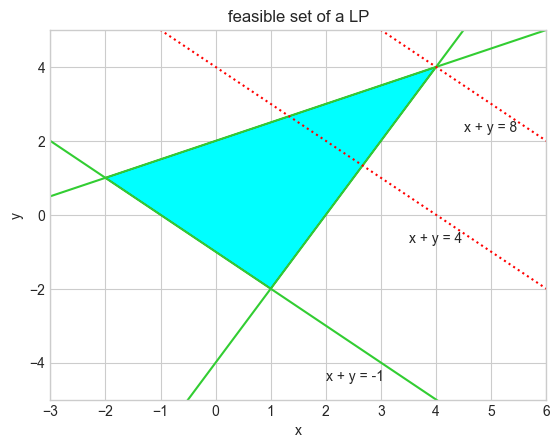

In [9]:
xp = np.array([-3,6])
# plot the constraints
plt.plot(xp,-xp - 1,xp,0.5*xp + 2,xp,2*xp - 4,color = 'limegreen') 
# Draw the lines
plt.plot(xp,-xp + 4,xp,-xp + 8,linestyle = 'dotted',color = 'red')
# Draw the feasible set (filled triangle)
path = mpl.path.Path([[4,4],[1,-2],[-2,1],[4,4]])            
patch = mpl.patches.PathPatch(path,facecolor = 'cyan')               
# Add the triangle to the plot
plt.gca().add_patch(patch)                                          
plt.xlabel('x')
plt.ylabel('y')
plt.title('feasible set of a LP')
plt.xlim(-3,6)
plt.ylim(-5,5)
plt.text(2,-4.5,"x + y = -1")
plt.text(3.5,-0.75,"x + y = 4")
plt.text(4.5,2.25,"x + y = 8")

***
## Least Square
***

In [10]:
X = np.array([1.47,1.5,1.52,1.55,1.57,
              1.6,1.63,1.65,1.68,1.7,
              1.73,1.75,1.78,1.80,1.83])
# model matrix
Xm = sm.add_constant(X)
y = np.array([52.21,53.12,54.48,55.84,57.2,
              58.57,59.93,61.29,63.11,64.47,
              66.28,68.1,69.92,72.19,74.46]).reshape(-1,1)

In [11]:
beta = cp.Variable((2,1))
obj = cp.Minimize(cp.sum_squares(y - Xm @ beta))
prob = cp.Problem(obj)
prob.solve()
# Print result.
display(prob.status,
        "The optimal value is {:.3f}".format(prob.value),
        "A solution (b0,b1) is ({:.3f},{:.3f})".format(*beta.value.ravel()))

'optimal'

'The optimal value is 7.491'

'A solution (b0,b1) is (-39.062,61.272)'

***
## Quadratic Program
***

In [12]:
df_sav = savings.load()
df_sav.head()

,sr,pop15,pop75,dpi,ddpi
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82
Bolivia,5.75,41.89,1.67,189.13,0.22
Brazil,12.88,42.19,0.83,728.47,4.56


In [13]:
Xc = sm.add_constant(df_sav.values[:,1:])
yc = df_sav.values[:,1].reshape(-1,1)
Am = np.array([[0,1,1,0,0]])
# define variable
beta = cp.Variable((5,1))
cstr = [Am @ beta == np.zeros((5,1))]
obj = cp.Minimize(cp.sum_squares(yc - Xc @ beta))
prob = cp.Problem(obj,cstr)
prob.solve()
display(prob.status,
        "The optimal value is {:.3f}".format(prob.value),
        "A solution beta is ({:.3f},{:.3f},{:.3f},{:.3f},{:.3f})".format(*beta.value.ravel()))

'optimal'

'The optimal value is 10.077'

'A solution beta is (5.223,0.902,-0.902,0.000,0.006)'

***
## Trade off curve
***

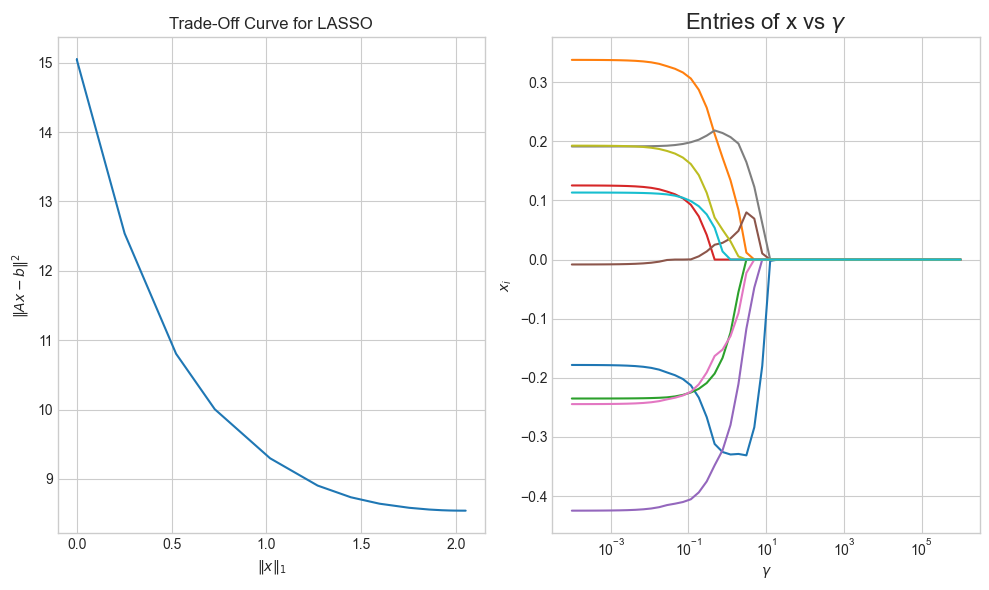

In [14]:
# Generate data
n,m = 15,10
np.random.seed(1)
A = np.random.randn(n,m)
b = np.random.randn(n)
# penal variable
gamma = cp.Parameter(nonneg = True)
# variable
x = cp.Variable(m)
# error part
error = cp.sum_squares(A @ x - b)
# objective
obj = cp.Minimize(error + gamma * cp.norm(x, 1))
prob = cp.Problem(obj)
# Construct a trade-off curve 
error_term = []
penal_term = []
x_vals = []
gamma_vals = np.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    error_term.append(error.value)
    penal_term.append(cp.norm(x, 1).value)
    x_vals.append(x.value)
plt.figure(figsize = (10,6))
# Plot trade-off curve.
plt.subplot(1,2,1)
plt.plot(penal_term,error_term)
plt.xlabel(r'$\|x\|_1$')
plt.ylabel(r'$\|Ax-b\|^2$')
plt.title('Trade-Off Curve for LASSO')
# Plot entries of x vs. gamma.
plt.subplot(1,2,2)
for i in range(m):
    plt.plot(gamma_vals,[xi[i] for xi in x_vals])
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$x_{i}$')
plt.xscale('log')
plt.title(r'Entries of x vs $\gamma$', fontsize=16)
plt.tight_layout()

***
## Lasso Problem
***

In [15]:
df_sd = statedata.load()
df_sd.set_index('State',inplace = True)
df_sd.head()

,Population,Income,Illiteracy,LifeExp,Murder,HSGrad,Frost,Area
State,,,,,,,,
AL,3615,3624,2.1,69.05,15.1,41.3,20,50708
AK,365,6315,1.5,69.31,11.3,66.7,152,566432
AZ,2212,4530,1.8,70.55,7.8,58.1,15,113417
AR,2110,3378,1.9,70.66,10.1,39.9,65,51945
CA,21198,5114,1.1,71.71,10.3,62.6,20,156361


In [16]:
# Coef vector
beta = cp.Variable((8,1))
# Data
y = df_sd.LifeExp.values.reshape(-1,1)
X = df_sd.drop('LifeExp',axis = 1).values
Xm = sm.add_constant(X)
# error part
error = cp.sum_squares(y - Xm @ beta)
# penal part
penalty = 1e-5 * cp.norm(beta,1)
# objective
obj = cp.Minimize(error + penalty) 
# Define
prob = cp.Problem(obj)
# Solve
prob.solve(solver = cp.CVXOPT)
display(prob.status,
        prob.value,
        beta.value)

'optimal'

np.float64(23.29785146825527)

array([[70.94320201],
       [ 0.0000518 ],
       [-0.0000218 ],
       [ 0.03382324],
       [-0.30112297],
       [ 0.04892968],
       [-0.00573498],
       [-0.00000007]])

***
## Lasso by Sklearn
***

In [17]:
model_lasso = Lasso(alpha = 1e-5,fit_intercept = True).fit(X,y)
np.concat([model_lasso.intercept_,
                   model_lasso.coef_]).reshape(-1,1)

array([[70.94363092],
       [ 0.0000518 ],
       [-0.00002181],
       [ 0.03369101],
       [-0.30111625],
       [ 0.04892536],
       [-0.00573561],
       [-0.00000007]])

***
## solve LP by linprog in Scipy.optimize
***

In [18]:
# linprog() solves only minimization (not maximization) problems
coef_obj = [-13,-23]
coef_A = [[5,15],
          [4,4],
          [35,20]]
bound_A = [480,
           160,
           1190]
bnd = [(0, float("inf")), # Bounds pf x
       (0, float("inf"))] # Bounds of y
opt = linprog(c = coef_obj,A_ub = coef_A,b_ub = bound_A,bounds = bnd)
display(f'{opt.message}',
        f'max profit = {-opt.fun:.1f}',
        '(Ale,Beer) = ({:.1f},{:.1f})'.format(*opt.x))

'Optimization terminated successfully. (HiGHS Status 7: Optimal)'

'max profit = 800.0'

'(Ale,Beer) = (12.0,28.0)'

***
## solve LP by CVXPY
***

In [19]:
X = cp.Variable((2,1),nonneg = True)
Am = np.array(coef_A)
b = np.array(bound_A).reshape(-1,1)
c = np.array(coef_obj).reshape(-1,1)
cstr = [Am @ X <= b]
obj = cp.Minimize(c.T @ X)
prob = cp.Problem(obj,cstr)
prob.solve()
display(prob.status,
        'max profit = {:.1f}'.format(prob.value * -1),
        '(Ale,Beer) = ({:.1f},{:.1f})'.format(*X.value.ravel()))

'optimal'

'max profit = 800.0'

'(Ale,Beer) = (12.0,28.0)'

***
## solve LP by PULP
***

In [20]:
from pulp import LpMaximize,LpProblem,LpStatus,lpSum,LpVariable
# Create the LP model
model = LpProblem(name = "Brewery",sense = LpMaximize)
# Initialize the decision variables
A = LpVariable(name = "Ale",lowBound = 0,cat = 'Integer')
B = LpVariable(name = "Beer",lowBound = 0,cat = 'Integer')
# Add the constraints to the model
model += (5 * A + 15 * B <= 480,"Corn limitation")
model += (4 * A + 4 * B <= 160,"Hops limitation")
model += (35 * A + 20 * B <= 1190,"Malt limitation")
# Add the objective function to the model
model += lpSum([13 * A,23 * B])
model

Brewery:
MAXIMIZE
13*Ale + 23*Beer + 0
SUBJECT TO
Corn_limitation: 5 Ale + 15 Beer <= 480

Hops_limitation: 4 Ale + 4 Beer <= 160

Malt_limitation: 35 Ale + 20 Beer <= 1190

VARIABLES
0 <= Ale Integer
0 <= Beer Integer

In [21]:
status = model.solve()
display(f"status: {model.status}, {LpStatus[model.status]}",
        f"objective: {model.objective.value()}")
for var in model.variables():
    print(f"{var.name}: {var.value()}")

'status: 1, Optimal'

'objective: 800.0'

Ale: 12.0
Beer: 28.0
